# 원본 트랙

In [1]:
npy_name = "reInvent2019_track_ccw.npy"

LOOK_AHEAD_POINTS = 5
MIN_SPEED = 1.3
MAX_SPEED = 4

# Number of times to iterate each new race line point
# keep this at 3-8 for best balance of performance and desired result
XI_ITERATIONS=8 # default 4

# Number of times to scan the entire race track to iterate
# 500 will get a good start, 1500 will be closer to optimal result
LINE_ITERATIONS=500 # default 1000

In [2]:
!git clone https://github.com/aws-deepracer-community/deepracer-race-data.git

Cloning into 'deepracer-race-data'...
remote: Enumerating objects: 525932, done.
remote: Counting objects: 100% (16841/16841), done.
remote: Compressing objects: 100% (435/435), done.
remote: Total 525932 (delta 16637), reused 16608 (delta 16406), pack-reused 509091 (from 1)
Receiving objects: 100% (525932/525932), 287.73 MiB | 44.44 MiB/s, done.
Resolving deltas: 100% (387589/387589), done.
Updating files: 100% (43876/43876), done.


In [3]:
import os

npy_folder_path = "deepracer-race-data/raw_data/tracks/npy"
TRACK_NAME = npy_name.split('.')[0]
numpy_file_path = os.path.join(npy_folder_path, npy_name)

In [4]:
import glob
import numpy as np
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString
import pandas as pd
import matplotlib.pyplot as plt
import os.path

Is loop/ring?  True


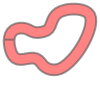

In [5]:
# Load the center, inner, outer waypoints
waypoints = np.load(numpy_file_path)

# Convert to Shapely objects
center_line = waypoints[:,0:2]
inner_border = waypoints[:,2:4]
outer_border = waypoints[:,4:6]
l_center_line = LineString(center_line)
l_inner_border = LineString(inner_border)
l_outer_border = LineString(outer_border)
road_poly = Polygon(np.vstack((outer_border, np.flipud(inner_border))))
print("Is loop/ring? ", l_center_line.is_ring)
road_poly

Is loop/ring?  True


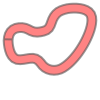

In [6]:
# Own code: Reduce width of track

def dist_2_points(x1, x2, y1, y2):
        return abs(abs(x1-x2)**2 + abs(y1-y2)**2)**0.5

def x_perc_width(waypoint, perc_width):

    center_x, center_y, inner_x, inner_y, outer_x, outer_y = waypoint

    width = dist_2_points(inner_x, outer_x, inner_y, outer_y)

    delta_x = outer_x-inner_x
    delta_y = outer_y-inner_y

    inner_x_new = inner_x + delta_x/2 * (1-perc_width)
    outer_x_new = outer_x - delta_x/2 * (1-perc_width)
    inner_y_new = inner_y + delta_y/2 * (1-perc_width)
    outer_y_new = outer_y - delta_y/2 * (1-perc_width)

    return [center_x, center_y, inner_x_new, inner_y_new, outer_x_new, outer_y_new]

PERC_WIDTH = 0.8
waypoints_new = [x_perc_width(waypoint, perc_width=PERC_WIDTH) for waypoint in waypoints]
waypoints_new = np.asarray(waypoints_new)

# Convert to Shapely objects
inner_border_new = waypoints_new[:,2:4]
outer_border_new = waypoints_new[:,4:6]
l_inner_border_new = LineString(inner_border_new)
l_outer_border_new = LineString(outer_border_new)
road_poly_new = Polygon(np.vstack((outer_border_new, np.flipud(inner_border_new))))
print("Is loop/ring? ", l_center_line.is_ring)
road_poly_new

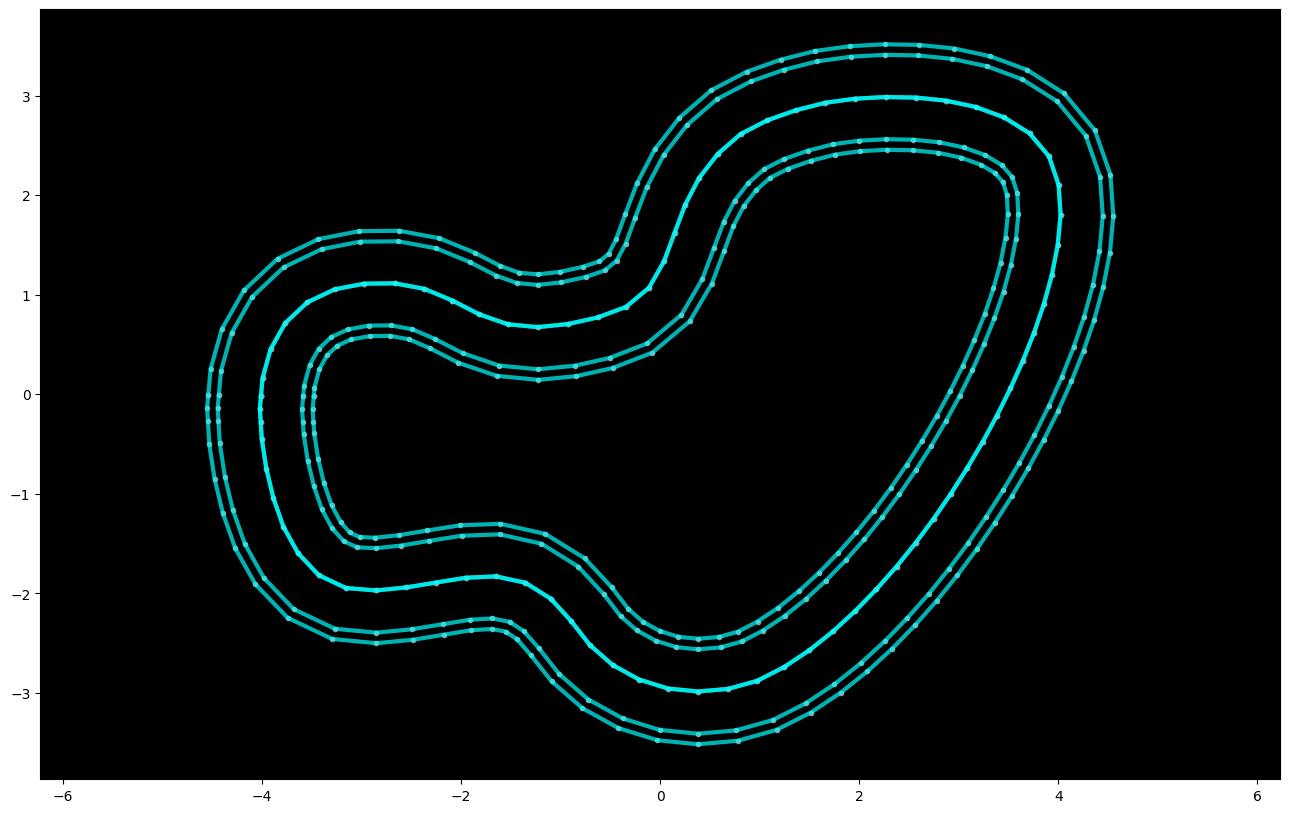

In [7]:
def plot_coords(ax, ob):
    x, y = ob.xy
    ax.plot(x, y, '.', color='#999999', zorder=1)

def plot_bounds(ax, ob):
    x, y = zip(*list((p.x, p.y) for p in ob.boundary))
    ax.plot(x, y, '.', color='#000000', zorder=1)

def plot_line(ax, ob):
    x, y = ob.xy
    ax.plot(x, y, color='cyan', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

def print_border(ax, waypoints, inner_border_waypoints, outer_border_waypoints):
    line = LineString(waypoints)
    plot_coords(ax, line)
    plot_line(ax, line)

    line = LineString(inner_border_waypoints)
    plot_coords(ax, line)
    plot_line(ax, line)

    line = LineString(outer_border_waypoints)
    plot_coords(ax, line)
    plot_line(ax, line)

fig = plt.figure(1, figsize=(16, 10))
ax = fig.add_subplot(111, facecolor='black')
plt.axis('equal')
print_border(ax, center_line, inner_border, outer_border)

# Also print new border
print_border(ax, center_line, inner_border_new, outer_border_new)

# A* 알고리즘 사용 race line

In [8]:
import os
import numpy as np
from heapq import heappop, heappush
from scipy.spatial import distance
import matplotlib.pyplot as plt
from shapely.geometry import LineString, Polygon, Point
import math

In [9]:
# Load the track data from the GitHub repository
npy_folder_path = "deepracer-race-data/raw_data/tracks/npy"
npy_name = "reInvent2019_track_ccw.npy"
numpy_file_path = os.path.join(npy_folder_path, npy_name)

# Check if the file exists
if not os.path.exists(numpy_file_path):
    raise FileNotFoundError(f"The file {npy_name} was not found in {npy_folder_path}.")

# Load the waypoints from the .npy file
waypoints = np.load(numpy_file_path)

# Extract center, inner, and outer waypoints
center_line = waypoints[:, 0:2]
inner_border = waypoints[:, 2:4]
outer_border = waypoints[:, 4:6]

In [10]:
# Check if a point is within the track boundaries
def is_valid_point(point, inner_border, outer_border):
    """Check if the point is within the track boundaries."""
    track_polygon = Polygon(np.vstack((outer_border, np.flipud(inner_border))))
    return track_polygon.contains(Point(point))

In [11]:
# Define the A* algorithm
def a_star_search(start, goal, grid, obstacles):
    """Perform A* search on a grid with obstacles."""
    open_set = []
    heappush(open_set, (0, start))  # Priority queue with (cost, node)
    came_from = {}
    g_score = {node: float('inf') for node in grid}
    g_score[start] = 0
    f_score = {node: float('inf') for node in grid}
    f_score[start] = heuristic(start, goal, obstacles, center_line)

    while open_set:
        current = heappop(open_set)[1]

        # If we loop back to the start, complete the path
        if current == goal and len(came_from) > 1:
            return reconstruct_path(came_from, current)

        for neighbor in get_neighbors(current, grid, obstacles):
            tentative_g_score = g_score[current] + distance.euclidean(current, neighbor)

            if tentative_g_score < g_score[neighbor]:
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g_score
                f_score[neighbor] = g_score[neighbor] + heuristic(neighbor, goal, obstacles, center_line)
                heappush(open_set, (f_score[neighbor], neighbor))

    return []  # Return empty if no path found

# 휴리스틱 가중치 조절


*   장애물 패널티
*   중심선 거리 패널티
* 직선성 보너스



In [12]:
def heuristic(node, goal, obstacles, center_line):
    """Improved heuristic for A* with straightness and centerline considerations."""
    # 기본 비용: 목표와의 유클리드 거리
    base_cost = math.sqrt((node[0] - goal[0])**2 + (node[1] - goal[1])**2)

    # 장애물 패널티
    obstacle_penalty = sum([
        3.0 / (Polygon(obstacle).distance(Point(node)) + 1e-6) for obstacle in obstacles
    ])

    # 중심선 거리 패널티
    centerline_penalty = centerline_proximity_penalty(node, center_line) * 4.5  # 가중치 2.5

    # 직선성 보너스
    straightness = straightness_bonus(node, goal, goal) * -3.0  # 가중치 -2.0 (보너스)

    # 총 휴리스틱 값
    return base_cost + obstacle_penalty + centerline_penalty + straightness

def straightness_bonus(current, neighbor, goal):
    """Reward for maintaining straight paths."""
    vector1 = (neighbor[0] - current[0], neighbor[1] - current[1])  # 이동 벡터
    vector2 = (goal[0] - current[0], goal[1] - current[1])          # 목표 방향 벡터
    norm1 = math.sqrt(vector1[0]**2 + vector1[1]**2)
    norm2 = math.sqrt(vector2[0]**2 + vector2[1]**2)
    dot_product = vector1[0] * vector2[0] + vector1[1] * vector2[1]
    angle_cos = dot_product / (norm1 * norm2 + 1e-6)  # 코사인 값
    return max(0, angle_cos)  # 직선 경로일수록 값이 1에 가까움

def centerline_proximity_penalty(node, center_line):
    """Penalty for distance from the track's center line."""
    return LineString(center_line).distance(Point(node))

neighbor) <= 0.5 #### 이부분 편집 가능
* 값 up -> 다음 노드를 더 멀리 탐색 가능
* 값 down -> 다음 노드 탐지 범위 좁아짐

In [13]:
def reconstruct_path(came_from, current):
    """Reconstruct the path from the came_from dictionary."""
    total_path = [current]
    while current in came_from:
        current = came_from[current]
        total_path.append(current)
    return total_path[::-1]

def get_neighbors(node, grid, obstacles):
    """Get valid neighbors for a node in the grid."""
    neighbors = []
    for neighbor in grid:
        if neighbor != node and distance.euclidean(node, neighbor) <= 0.5: #편집 가능
            if not is_obstacle(neighbor, obstacles):
                neighbors.append(neighbor)
    return neighbors

In [14]:
def is_obstacle(node, obstacles):
    """Check if a node is an obstacle."""
    for obstacle in obstacles:
        if Polygon(obstacle).contains(Point(node)):
            return True
    return False

In [18]:
# Create the grid around the track
def create_grid(center_line, resolution, inner_border, outer_border):
    """Generate a grid around the center line, constrained by track boundaries."""
    grid = []
    for point in center_line:
        x, y = point
        potential_points = [
            (x + dx, y + dy)
            for dx in np.linspace(-resolution, resolution, 5)
            for dy in np.linspace(-resolution, resolution, 5)
        ]
        valid_points = [p for p in potential_points if is_valid_point(p, inner_border, outer_border)]
        grid.extend(valid_points)
    return list(set(grid))  # Remove duplicates

In [19]:
def calculate_obstacle_position(center_line, location_percentage, lane, inner_border, outer_border, offset_factor=0.4):
    """
    Determine obstacle positions based on location percentage and lane.
    Obstacles are shifted toward the center line by `offset_factor`.
    """
    total_length = LineString(center_line).length
    # Get the point along the center line
    obstacle_point = LineString(center_line).interpolate(total_length * location_percentage)
    x, y = obstacle_point.x, obstacle_point.y

    # Find the closest index on the center line
    closest_idx = np.argmin([np.linalg.norm(np.array([x, y]) - np.array(point)) for point in center_line])
    inner_point = np.array(inner_border[closest_idx])
    outer_point = np.array(outer_border[closest_idx])
    center_point = np.array(center_line[closest_idx])

    # Move obstacle toward the center line
    if lane == "inside":
        obstacle_position = inner_point + (center_point - inner_point) * offset_factor
    elif lane == "outside":
        obstacle_position = outer_point + (center_point - outer_point) * offset_factor
    else:
        raise ValueError("Lane must be 'inside' or 'outside'.")

    # Return as a rectangular polygon
    obstacle_size = 0.3  # Adjust size to ensure clear pathfinding
    return Polygon([
        (obstacle_position[0] - obstacle_size, obstacle_position[1] - obstacle_size),
        (obstacle_position[0] + obstacle_size, obstacle_position[1] - obstacle_size),
        (obstacle_position[0] + obstacle_size, obstacle_position[1] + obstacle_size),
        (obstacle_position[0] - obstacle_size, obstacle_position[1] + obstacle_size)
    ])

In [20]:
def resample_and_remove_duplicates(paths, target_spacing=0.1):
    """
    각 path를 균일한 간격으로 재샘플링하고, 중복된 값을 제거하여 유니크한 좌표 리스트 반환.
    - paths: A* 경로 리스트 [[(x1, y1), (x2, y2), ...], ...]
    - target_spacing: 샘플링 간격
    """
    resampled_paths = []

    for path in paths:
        if len(path) < 2:  # 경로에 충분한 점이 없으면 스킵
            continue

        # x, y 좌표 분리
        x_coords = [point[0] for point in path]
        y_coords = [point[1] for point in path]

        # 거리 누적 계산
        distances = [0] + list(np.cumsum(np.sqrt(np.diff(x_coords)**2 + np.diff(y_coords)**2)))

        # 목표 간격에 맞게 새 좌표 생성
        new_distances = np.arange(0, distances[-1], target_spacing)
        new_x_coords = np.interp(new_distances, distances, x_coords)
        new_y_coords = np.interp(new_distances, distances, y_coords)

        # 중복 제거: (x, y)를 튜플로 묶어 Set으로 변환 후 리스트로 변환
        resampled_path = list(set((x, y) for x, y in zip(new_x_coords, new_y_coords)))

        # 정렬: 재샘플링 후 순서를 유지하기 위해 정렬
        resampled_path = sorted(resampled_path, key=lambda point: distances[np.argmin(
            [np.linalg.norm(np.array(point) - np.array(original)) for original in path]
        )])

        resampled_paths.append(resampled_path)

    return resampled_paths

Grid resolution 조절 가능

Paths saved to resampled_paths.npy


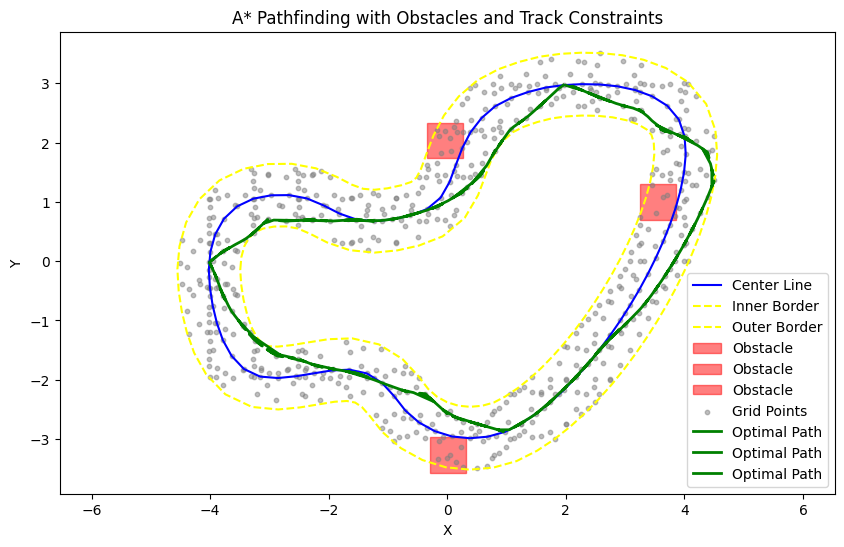

In [21]:
# Define obstacles with improved placement
obstacles = [
    calculate_obstacle_position(center_line, 0.25, "outside", inner_border, outer_border),
    calculate_obstacle_position(center_line, 0.50, "inside", inner_border, outer_border),
    calculate_obstacle_position(center_line, 0.75, "outside", inner_border, outer_border)
]

# Create grid and define start and goal
resolution = 1.5  # Grid resolution
grid = create_grid(center_line, resolution, inner_border, outer_border)
start = tuple(center_line[0])  # Start at the first point of the center line
middle1 = tuple(center_line[len(center_line) // 3])  # Goal 1/3way around the track
middle2 = tuple(center_line[len(center_line) // 3 * 2])  # Goal 2/3way around the track
goal = tuple(center_line[0])  # Goal at the first point of the center line

# Perform A* search with progress tracking
path1 = a_star_search(start, middle1, grid, obstacles)
path2 = a_star_search(middle1, middle2, grid, obstacles)
path3 = a_star_search(middle2, goal, grid, obstacles)

# 모든 path를 샘플링 및 유니크 처리
paths = [path1, path2, path3]
target_spacing = 0.1  # 샘플링 간격 설정
resampled_paths = resample_and_remove_duplicates(paths, target_spacing)

# Save resampled paths to NDArray with dtype=object
np.save("resampled_paths.npy", np.array(resampled_paths, dtype=object))
print("Paths saved to resampled_paths.npy")

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(*zip(*center_line), label="Center Line", color="blue")
plt.plot(*zip(*inner_border), color="yellow", linestyle="--", label="Inner Border")
plt.plot(*zip(*outer_border), color="yellow", linestyle="--", label="Outer Border")
for obstacle in obstacles:
    obstacle_polygon = Polygon(obstacle)
    x, y = obstacle_polygon.exterior.xy
    plt.fill(x, y, color="red", alpha=0.5, label="Obstacle")
plt.scatter(*zip(*grid), color="grey", s=10, alpha=0.5, label="Grid Points")

for path in resampled_paths:
    if path:
        plt.plot(*zip(*path), label="Optimal Path", color="green", linewidth=2)

plt.legend()
plt.title("A* Pathfinding with Obstacles and Track Constraints")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis("equal")
plt.show()

waypoint 개수 동일해지게 조절

In [22]:
def force_equal_waypoints_count(resampled_paths, original_count):
    """원본 웨이포인트 개수와 동일하도록 재샘플링."""
    combined_path = [point for path in resampled_paths for point in path]
    distances = [0] + list(np.cumsum(np.sqrt(np.diff([p[0] for p in combined_path])**2 +
                                             np.diff([p[1] for p in combined_path])**2)))
    new_distances = np.linspace(0, distances[-1], original_count)
    x_coords = np.interp(new_distances, distances, [p[0] for p in combined_path])
    y_coords = np.interp(new_distances, distances, [p[1] for p in combined_path])
    return list(zip(x_coords, y_coords))

# 강제 조정
forced_resampled_path = force_equal_waypoints_count(resampled_paths, len(center_line))

# 결과 확인
print(f"Original waypoints count: {len(center_line)}")
print(f"Forced resampled waypoints count: {len(forced_resampled_path)}")

# # Save resampled paths to NDArray with dtype=object
np.save("resampled_paths.npy", forced_resampled_path)
print("Paths saved to resampled_paths.npy")

Original waypoints count: 79
Forced resampled waypoints count: 79
Paths saved to resampled_paths.npy


#Optimal Path 경로 NDarray 저장


*   Input: .py file with 2D array containing optimal racing line: 2 columns (x,y)
*   Output: .py file with 2D array: 4 columns (x,y,speed,expected time). This array can be inserted into the reward function

In [23]:
import numpy as np

npy_file = "resampled_paths.npy"
data = np.load(npy_file, allow_pickle=True)

# Flatten the list of paths into a single 2D array of (x, y) points
flattened_data = np.vstack(data)

# Define the output .py file name
npy_output_file = "optimal_racing_line.npy"

# Save the 2D array to the .npy file
np.save(npy_output_file, flattened_data)

print(f"Optimal racing line saved to {npy_output_file}")

Optimal racing line saved to optimal_racing_line.npy


# Optimal Speed 계산

In [24]:
%matplotlib inline

import numpy as np
import pandas as pd
from scipy import stats
import math

# Ignore deprecation warnings we have no power over
import warnings
warnings.filterwarnings('ignore')

In [25]:
# Path of the optimal racing line (.npy file)
fpath = "optimal_racing_line.npy"

# Change manually (this is only so that output files are named correctly)
TRACK_NAME = "SmileSpeedway"

racing_track_o = np.load(fpath)

# Convert np array to list and remove last point because it is the same point as the first one
racing_track_o = racing_track_o.tolist()[:-1]

racing_track = np.unique(np.array(racing_track_o), axis=0)

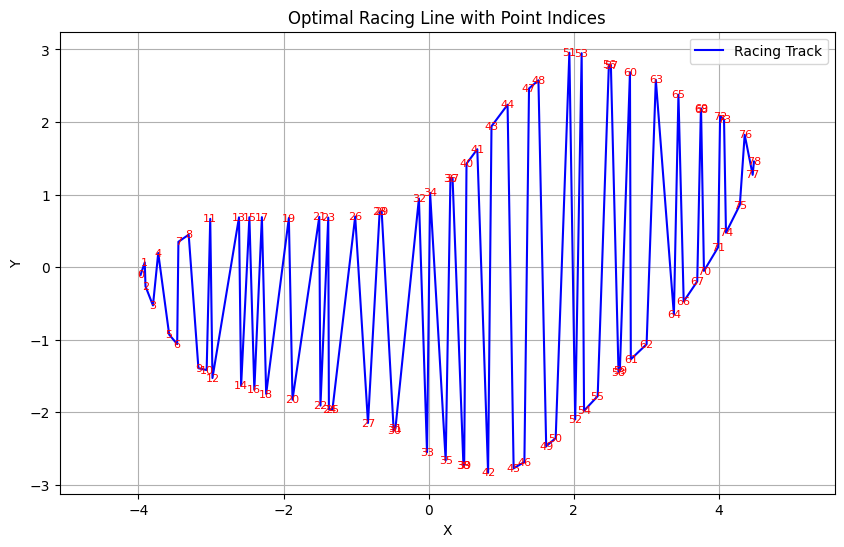

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Load the optimal racing line data
fpath = "optimal_racing_line.npy"
racing_track = np.load(fpath)

# Remove duplicates and convert to unique path
racing_track = np.unique(racing_track, axis=0)

# Plot the racing track
plt.figure(figsize=(10, 6))
plt.plot(racing_track[:, 0], racing_track[:, 1], label="Racing Track", color="blue")

# Annotate each point with its index
for idx, (x, y) in enumerate(racing_track):
    plt.text(x, y, str(idx), fontsize=8, color="red", ha="center", va="center")

# Labels and title
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Optimal Racing Line with Point Indices")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()

시계방향/반시계방향 확인

(만약 방향 반대일 경우 코드 재실행시키면 됨)

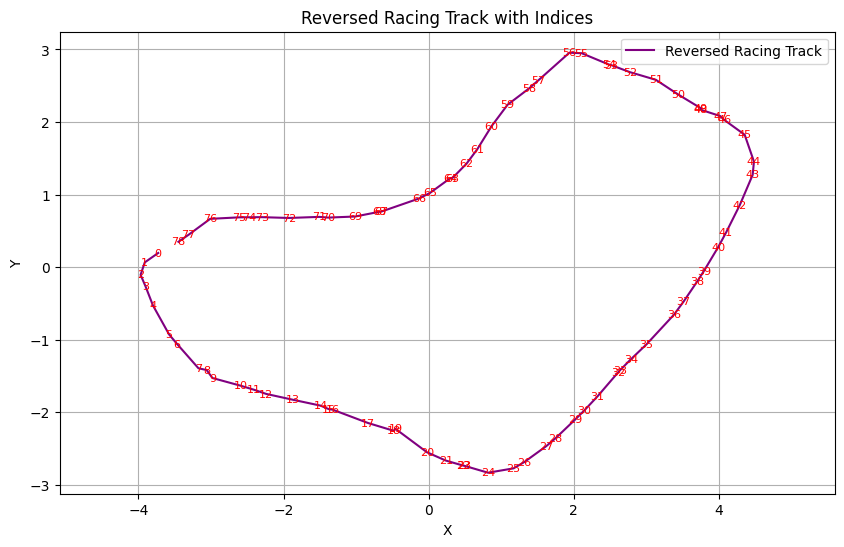

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance


# Reorder waypoints by proximity
def reorder_waypoints(waypoints):
    """Reorder waypoints to form a continuous path."""
    ordered = [waypoints[0]]  # Start with the first waypoint
    waypoints = list(waypoints[1:])  # Remaining waypoints

    while waypoints:
        # Find the closest waypoint to the last added point
        last_point = ordered[-1]
        distances = [distance.euclidean(last_point, wp) for wp in waypoints]
        closest_idx = np.argmin(distances)

        # Add the closest waypoint to the ordered list
        ordered.append(waypoints.pop(closest_idx))

    return np.array(ordered)

# Reorder the racing track
ordered_racing_track = reorder_waypoints(racing_track)

# Reverse the order for the opposite direction
reversed_racing_track = ordered_racing_track[::-1]

# Save reversed track (optional)
np.save("reversed_racing_track.npy", reversed_racing_track)

# Plot the reversed track
plt.figure(figsize=(10, 6))
plt.plot(reversed_racing_track[:, 0], reversed_racing_track[:, 1], label="Reversed Racing Track", color="purple")

# Annotate indices
for idx, (x, y) in enumerate(reversed_racing_track):
    plt.text(x, y, str(idx), fontsize=8, color="red", ha="center", va="center")

plt.xlabel("X")
plt.ylabel("Y")
plt.title("Reversed Racing Track with Indices")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()

racing_track = reversed_racing_track

In [31]:
# Uses previous and next coords to calculate the radius of the curve
# so you need to pass a list with form [[x1,y1],[x2,y2],[x3,y3]]
# Input 3 coords [[x1,y1],[x2,y2],[x3,y3]]
def circle_radius(coords):

    # Flatten the list and assign to variables (makes code easier to read later)
    x1, y1, x2, y2, x3, y3 = [i for sub in coords for i in sub]

    a = x1*(y2-y3) - y1*(x2-x3) + x2*y3 - x3*y2
    b = (x1**2+y1**2)*(y3-y2) + (x2**2+y2**2)*(y1-y3) + (x3**2+y3**2)*(y2-y1)
    c = (x1**2+y1**2)*(x2-x3) + (x2**2+y2**2)*(x3-x1) + (x3**2+y3**2)*(x1-x2)
    d = (x1**2+y1**2)*(x3*y2-x2*y3) + (x2**2+y2**2) * \
        (x1*y3-x3*y1) + (x3**2+y3**2)*(x2*y1-x1*y2)

    # In case a is zero (so radius is infinity)
    try:
        r = abs((b**2+c**2-4*a*d) / abs(4*a**2)) ** 0.5
    except:
        r = 999

    return r


# Returns indexes of next index and index+lookfront
# We need this to calculate the radius for next track section.
def circle_indexes(mylist, index_car, add_index_1=0, add_index_2=0):

    list_len = len(mylist)

    # if index >= list_len:
    #     raise ValueError("Index out of range in circle_indexes()")

    # Use modulo to consider that track is cyclical
    index_1 = (index_car + add_index_1) % list_len
    index_2 = (index_car + add_index_2) % list_len

    return [index_car, index_1, index_2]


def optimal_velocity(track, min_speed, max_speed, look_ahead_points):

    # Calculate the radius for every point of the track
    radius = []
    for i in range(len(track)):
        indexes = circle_indexes(track, i, add_index_1=-1, add_index_2=1)
        coords = [track[indexes[0]],
                  track[indexes[1]], track[indexes[2]]]
        radius.append(circle_radius(coords))

    # Get the max_velocity for the smallest radius
    # That value should multiplied by a constant multiple
    v_min_r = min(radius)**0.5
    constant_multiple = min_speed / v_min_r
    print(f"Constant multiple for optimal speed: {constant_multiple}")

    if look_ahead_points == 0:
        # Get the maximal velocity from radius
        max_velocity = [(constant_multiple * i**0.5) for i in radius]
        # Get velocity from max_velocity (cap at MAX_SPEED)
        velocity = [min(v, max_speed) for v in max_velocity]
        return velocity

    else:
        # Looks at the next n radii of points and takes the minimum
        # goal: reduce lookahead until car crashes bc no time to break
        LOOK_AHEAD_POINTS = look_ahead_points
        radius_lookahead = []
        for i in range(len(radius)):
            next_n_radius = []
            for j in range(LOOK_AHEAD_POINTS+1):
                index = circle_indexes(
                    mylist=radius, index_car=i, add_index_1=j)[1]
                next_n_radius.append(radius[index])
            radius_lookahead.append(min(next_n_radius))
        max_velocity_lookahead = [(constant_multiple * i**0.5)
                                  for i in radius_lookahead]
        velocity_lookahead = [min(v, max_speed)
                              for v in max_velocity_lookahead]
        return velocity_lookahead


# For each point in racing track, check if left curve (returns boolean)
def is_left_curve(coords):

    # Flatten the list and assign to variables (makes code easier to read later)
    x1, y1, x2, y2, x3, y3 = [i for sub in coords for i in sub]

    return ((x2-x1)*(y3-y1) - (y2-y1)*(x3-x1)) > 0


# Calculate the distance between 2 points
def dist_2_points(x1, x2, y1, y2):
        return abs(abs(x1-x2)**2 + abs(y1-y2)**2)**0.5

In [44]:
LOOK_AHEAD_POINTS = 5
MIN_SPEED = 1.5
MAX_SPEED = 4.0

# Calculate optimal speed
velocity = optimal_velocity(track=racing_track,
    min_speed=MIN_SPEED, max_speed=MAX_SPEED, look_ahead_points=LOOK_AHEAD_POINTS)

Constant multiple for optimal speed: 3.9464067480571257


Constant multiple for optimal speed: 3.9464067480571257


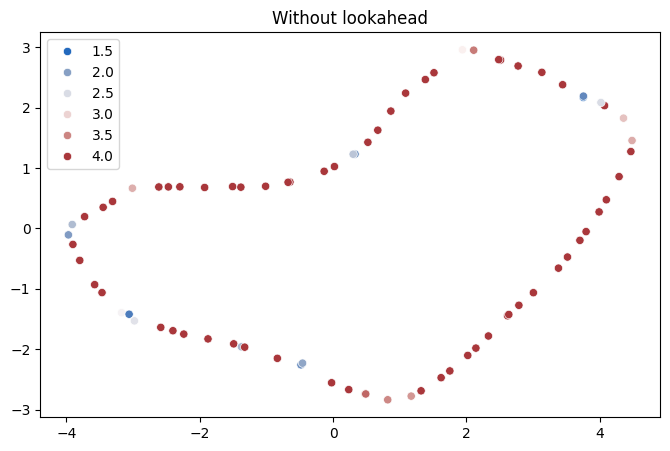

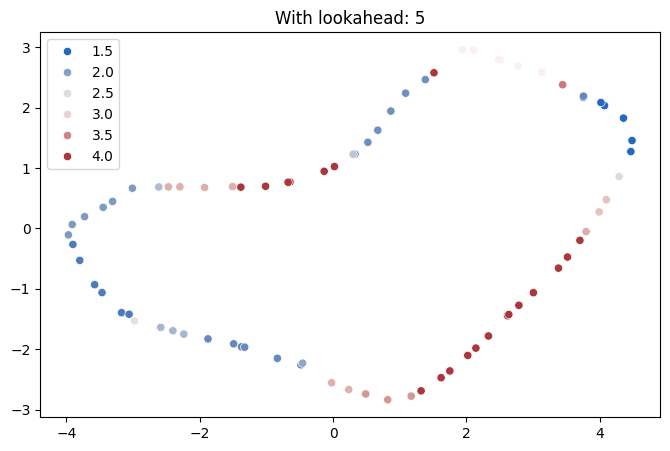

In [37]:
from matplotlib import pyplot as plt
import seaborn as sns

x = [i[0] for i in racing_track]
y = [i[1] for i in racing_track]

# Without lookahead
velocity_no_lookahead = optimal_velocity(track=racing_track,
    min_speed=MIN_SPEED, max_speed=MAX_SPEED, look_ahead_points=0)

fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.scatterplot(x=x, y=y, hue=velocity_no_lookahead,
                     palette="vlag").set_title("Without lookahead")

fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.scatterplot(x=x, y=y, hue=velocity, palette="vlag").set_title(
    f"With lookahead: {LOOK_AHEAD_POINTS}")

In [38]:
distance_to_prev = []
for i in range(len(racing_track)):
    indexes = circle_indexes(racing_track, i, add_index_1=-1, add_index_2=0)[0:2]
    coords = [racing_track[indexes[0]],racing_track[indexes[1]]]
    dist_to_prev = dist_2_points(x1=coords[0][0], x2=coords[1][0], y1=coords[0][1], y2=coords[1][1])
    distance_to_prev.append(dist_to_prev)

time_to_prev = [(distance_to_prev[i]/velocity[i]) for i in range(len(racing_track))]

total_time = sum(time_to_prev)
print(f"Total time for track, if racing line and speeds are followed perfectly: {total_time} s")

Total time for track, if racing line and speeds are followed perfectly: 8.971718963612076 s


In [39]:
# Now we have list with columns (x,y,speed,distance,time)
racing_track_everything = []
for i in range(len(racing_track)):
    racing_track_everything.append([racing_track[i][0],
                                    racing_track[i][1],
                                    velocity[i],
                                    time_to_prev[i]])
# Round to 5 decimals
racing_track_everything = np.around(racing_track_everything, 5).tolist()

In [40]:
print(len(racing_track_everything))

79


In [41]:
# Write to txt file
with open(f'optimals_newest_{TRACK_NAME}.txt', 'w') as f:
    f.write("[")
    for line in racing_track_everything:
        f.write("%s" % line)
        if line != racing_track_everything[-1]:
            f.write(",\n")
    f.write("]")

In [42]:
# 텍스트 파일 경로
file_path = "optimals_newest_SmileSpeedway.txt"

# 텍스트 파일 읽기
with open(file_path, "r") as file:
    content = file.read()  # 파일의 모든 내용을 읽음

# 텍스트 파일 내용 출력
print(content)

[[-3.72681, 0.19509, 1.96512, 0.16188],
[-3.91231, 0.06546, 1.96512, 0.11516],
[-3.96982, -0.10619, 1.96512, 0.09212],
[-3.90234, -0.26406, 1.66683, 0.103],
[-3.79946, -0.52828, 1.66683, 0.1701],
[-3.57596, -0.9296, 1.66683, 0.27559],
[-3.46562, -1.06099, 1.66683, 0.10293],
[-3.17281, -1.39356, 1.66683, 0.26584],
[-3.0592, -1.41888, 1.66683, 0.06983],
[-2.97936, -1.52858, 2.55048, 0.0532],
[-2.58424, -1.63631, 2.20681, 0.18558],
[-2.40218, -1.69173, 2.20681, 0.08624],
[-2.23901, -1.74753, 2.20681, 0.07814],
[-1.87589, -1.82694, 1.80696, 0.2057],
[-1.49049, -1.90888, 1.80696, 0.21806],
[-1.37424, -1.95797, 1.80696, 0.06983],
[-1.32548, -1.96374, 1.80696, 0.02717],
[-0.83545, -2.14844, 1.80696, 0.28981],
[-0.4809, -2.25592, 1.80696, 0.20503],
[-0.45756, -2.22791, 2.06464, 0.01766],
[-0.02171, -2.55242, 3.21386, 0.16908],
[0.23568, -2.66587, 3.21386, 0.08752],
[0.48038, -2.73688, 3.21386, 0.07928],
[0.4905, -2.7377, 3.38204, 0.003],
[0.82017, -2.834, 3.38204, 0.10155],
[1.17232, -2.77343,

# 보상함수

In [ ]:
import math

class Reward:
    def __init__(self, verbose=False):
        self.first_racingpoint_index = None
        self.verbose = verbose

    def reward_function(self, params):

        ################## HELPER FUNCTIONS ###################

        def dist_2_points(x1, x2, y1, y2):
            return math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

        def closest_2_racing_points_index(racing_coords, car_coords):
            distances = [
                dist_2_points(racing_coords[i][0], car_coords[0], racing_coords[i][1], car_coords[1])
                for i in range(len(racing_coords))
            ]
            closest_index = distances.index(min(distances))
            distances_no_closest = distances.copy()
            distances_no_closest[closest_index] = float("inf")
            second_closest_index = distances_no_closest.index(min(distances_no_closest))
            return [closest_index, second_closest_index]

        def dist_to_racing_line(closest_coords, second_closest_coords, car_coords):
            a = dist_2_points(*closest_coords, *second_closest_coords)
            b = dist_2_points(*car_coords, *closest_coords)
            c = dist_2_points(*car_coords, *second_closest_coords)
            try:
                distance = abs(-(a**4) + 2 * (a**2) * (b**2) + 2 * (a**2) * (c**2) -
                               (b**4) + 2 * (b**2) * (c**2) - (c**4)) ** 0.5 / (2 * a)
            except ZeroDivisionError:
                distance = b
            return distance

        def racing_direction_diff(closest_coords, second_closest_coords, car_coords, heading):
            next_vector = [second_closest_coords[0] - closest_coords[0], second_closest_coords[1] - closest_coords[1]]
            car_vector = [car_coords[0] - closest_coords[0], car_coords[1] - closest_coords[1]]
            track_angle = math.atan2(next_vector[1], next_vector[0])
            car_angle = math.radians(heading)
            angle_diff = abs(math.degrees(track_angle - car_angle))
            return angle_diff if angle_diff <= 180 else 360 - angle_diff

        #################### RACING LINE ######################
        racing_track = [[-3.72681, 0.19509, 1.96512, 0.16188],
                        [-3.91231, 0.06546, 1.96512, 0.11516],
                        [-3.96982, -0.10619, 1.96512, 0.09212],
                        [-3.90234, -0.26406, 1.66683, 0.103],
                        [-3.79946, -0.52828, 1.66683, 0.1701],
                        [-3.57596, -0.9296, 1.66683, 0.27559],
                        [-3.46562, -1.06099, 1.66683, 0.10293],
                        [-3.17281, -1.39356, 1.66683, 0.26584],
                        [-3.0592, -1.41888, 1.66683, 0.06983],
                        [-2.97936, -1.52858, 2.55048, 0.0532],
                        [-2.58424, -1.63631, 2.20681, 0.18558],
                        [-2.40218, -1.69173, 2.20681, 0.08624],
                        [-2.23901, -1.74753, 2.20681, 0.07814],
                        [-1.87589, -1.82694, 1.80696, 0.2057],
                        [-1.49049, -1.90888, 1.80696, 0.21806],
                        [-1.37424, -1.95797, 1.80696, 0.06983],
                        [-1.32548, -1.96374, 1.80696, 0.02717],
                        [-0.83545, -2.14844, 1.80696, 0.28981],
                        [-0.4809, -2.25592, 1.80696, 0.20503],
                        [-0.45756, -2.22791, 2.06464, 0.01766],
                        [-0.02171, -2.55242, 3.21386, 0.16908],
                        [0.23568, -2.66587, 3.21386, 0.08752],
                        [0.48038, -2.73688, 3.21386, 0.07928],
                        [0.4905, -2.7377, 3.38204, 0.003],
                        [0.82017, -2.834, 3.38204, 0.10155],
                        [1.17232, -2.77343, 3.38204, 0.10565],
                        [1.32051, -2.68591, 4.0, 0.04303],
                        [1.62107, -2.46849, 4.0, 0.09274],
                        [1.75195, -2.35685, 4.0, 0.04301],
                        [2.02089, -2.10028, 4.0, 0.09292],
                        [2.14289, -1.97923, 4.0, 0.04297],
                        [2.33074, -1.77888, 4.0, 0.06866],
                        [2.618, -1.44418, 4.0, 0.11027],
                        [2.63646, -1.42331, 4.0, 0.00697],
                        [2.78762, -1.27089, 4.0, 0.05367],
                        [3.00522, -1.06268, 4.0, 0.07529],
                        [3.38138, -0.65662, 4.0, 0.13838],
                        [3.5166, -0.47278, 4.0, 0.05706],
                        [3.7031, -0.19685, 4.0, 0.08326],
                        [3.79577, -0.05219, 3.24739, 0.0529],
                        [3.99082, 0.27367, 3.10691, 0.12224],
                        [4.09936, 0.47439, 3.10691, 0.07344],
                        [4.29062, 0.85742, 2.49727, 0.17144],
                        [4.46736, 1.27205, 1.5, 0.30048],
                        [4.48501, 1.45456, 1.5, 0.12224],
                        [4.35712, 1.82463, 1.5, 0.26103],
                        [4.07253, 2.03164, 1.5, 0.23461],
                        [4.01847, 2.08323, 1.5, 0.04982],
                        [3.75338, 2.16908, 1.5, 0.18576],
                        [3.75562, 2.18867, 1.78829, 0.01103],
                        [3.444, 2.37757, 3.56958, 0.10208],
                        [3.13222, 2.58237, 2.80866, 0.13282],
                        [2.77587, 2.6875, 2.80866, 0.13228],
                        [2.51269, 2.78636, 2.80866, 0.1001],
                        [2.48519, 2.79268, 2.80866, 0.01005],
                        [2.10987, 2.94883, 2.80866, 0.14473],
                        [1.94055, 2.95551, 2.80866, 0.06033],
                        [1.51403, 2.5757, 4.0, 0.14278],
                        [1.38443, 2.46295, 1.86179, 0.09227],
                        [1.08865, 2.23836, 1.86179, 0.19948],
                        [0.86701, 1.94142, 1.86179, 0.19902],
                        [0.67138, 1.62549, 1.86179, 0.19959],
                        [0.52269, 1.42538, 1.86179, 0.1339],
                        [0.33033, 1.22987, 1.86179, 0.14732],
                        [0.30139, 1.22801, 2.32608, 0.01246],
                        [0.02084, 1.02385, 4.0, 0.08674],
                        [-0.13335, 0.94544, 4.0, 0.04324],
                        [-0.64671, 0.76729, 4.0, 0.13585],
                        [-0.6746, 0.76359, 4.0, 0.00703],
                        [-1.01177, 0.69768, 4.0, 0.08589],
                        [-1.38292, 0.68294, 4.0, 0.09286],
                        [-1.50685, 0.69259, 3.22145, 0.03859],
                        [-1.92623, 0.67769, 3.22145, 0.13026],
                        [-2.2979, 0.68878, 3.22145, 0.11543],
                        [-2.47015, 0.68754, 3.22145, 0.05347],
                        [-2.61348, 0.68612, 2.25022, 0.0637],
                        [-3.01006, 0.66564, 1.96512, 0.20208],
                        [-3.307, 0.4471, 1.96512, 0.18762],
                        [-3.44857, 0.3493, 1.96512, 0.08756]]

        ################## INPUT PARAMETERS ###################
        all_wheels_on_track = params['all_wheels_on_track']
        x, y = params['x'], params['y']
        distance_from_center = params['distance_from_center']
        heading = params['heading']
        progress = params['progress']
        steps = params['steps']
        speed = params['speed']
        track_width = params['track_width']

        ################## REWARD CALCULATIONS ################

        # 기본 보상
        reward = 1.0

        # 경주 라인 근접성 보상
        closest_index, second_closest_index = closest_2_racing_points_index(racing_track, [x, y])
        closest_point = racing_track[closest_index]
        second_closest_point = racing_track[second_closest_index]
        distance = dist_to_racing_line(closest_point[:2], second_closest_point[:2], [x, y])
        reward += max(1e-3, 1 - (distance / (track_width * 0.5))) * 1.5

        # 최적 속도 보상
        optimal_speed = closest_point[2]
        speed_diff = abs(optimal_speed - speed)
        reward += max(1e-3, 1 - (speed_diff / optimal_speed)) * 2.0

        # 진행률에 따른 보너스
        if progress == 100:  # 랩 완료
            reward += 200

        # 방향 차이 페널티
        direction_diff = racing_direction_diff(closest_point[:2], second_closest_point[:2], [x, y], heading)
        if direction_diff > 30:
            reward *= 0.5

        # 트랙 이탈 페널티
        if not all_wheels_on_track or distance_from_center > (track_width / 2):
            reward = 1e-3

        ####################### VERBOSE #######################
        if self.verbose:
            print(f"Closest index: {closest_index}")
            print(f"Distance to racing line: {distance:.2f}")
            print(f"Speed diff: {speed_diff:.2f}, Optimal speed: {optimal_speed:.2f}")
            print(f"Direction diff: {direction_diff:.2f}")
            print(f"Reward: {reward:.2f}")

        #################### RETURN REWARD ####################
        return float(reward)


reward_object = Reward(verbose=True)


def reward_function(params):
    return reward_object.reward_function(params)
